In [1]:
import os
os.chdir('../..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LinearRegression
from collections import Iterable
import random
from os import listdir
from os.path import isfile, join
import matplotlib.patches as mpatches


import scipy.stats as st

import seaborn as sns
sns.set_style("whitegrid")

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

D:\Users\glede\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  


# Calculations for stats and plots are based on: https://github.com/stasmix/popsynth/blob/master/pop-synth-vae.ipynb

In [3]:
only_cat = False

# Load the files

In [4]:
dataset = 'Chicago'

In [5]:
synth_dir = '../synth_data/' + dataset

files = ['../data/' + dataset + '/data.csv']
labels = ['original']

for f in listdir(synth_dir):
    if isfile(join(synth_dir, f)):
        files.append(join(synth_dir, f))
        labels.append(f.split('.')[0])

In [6]:
labels

['original',
 'CTGAN',
 'SGAN_OR_BO',
 'SGAN_OR_NO',
 'SGAN_OR_OD',
 'SGAN_WI_BO',
 'SGAN_WI_NO',
 'SGAN_WI_OD',
 'SGAN_WO_BO',
 'SGAN_WO_NO',
 'SGAN_WO_OD',
 'TEST_BO',
 'TEST_NO',
 'TGAN',
 'VAE',
 'WGAN',
 'WGAN_OR_BO',
 'WGAN_OR_NO',
 'WGAN_OR_OD',
 'WGAN_WI_BO',
 'WGAN_WI_NO',
 'WGAN_WI_OD',
 'WGAN_WO_BO',
 'WGAN_WO_NO',
 'WGAN_WO_OD',
 'WGGP_OR_BO',
 'WGGP_OR_NO',
 'WGGP_OR_OD',
 'WGGP_WI_BO',
 'WGGP_WI_NO',
 'WGGP_WI_OD',
 'WGGP_WO_BO',
 'WGGP_WO_NO',
 'WGGP_WO_OD']

In [7]:
if dataset is 'Chicago':
    continuous_cols = ['distance', 'age', 'departure_time']
elif dataset is 'LPMC':
    continuous_cols = ['start_time_linear', 'age', 'distance', 'dur_walking', 'dur_cycling', 'dur_pt_access', 'dur_pt_rail', 'dur_pt_bus', 'dur_pt_int', 'dur_driving', 'cost_transit', 'cost_driving_fuel', 'driving_traffic_percent']

In [8]:
dfs = [pd.read_csv(file) for file in files]

In [9]:
if only_cat:
    print("REMOVING CONT")
    for i in range(len(dfs)):
        dfs[i] = dfs[i].drop(continuous_cols, axis=1)

# Transform all values in numerical

In [10]:
dfs[0].dtypes

choice              object
travel_dow           int64
trip_purpose        object
distance           float64
hh_vehicles          int64
hh_size              int64
hh_bikes             int64
hh_descr            object
hh_income            int64
gender               int64
age                  int64
license              int64
education_level      int64
work_status         object
departure_time     float64
dtype: object

In [11]:
if dataset is 'Chicago':
    ints = ['travel_dow', 'hh_vehicles', 'hh_size', 'hh_bikes', 'hh_income', 'gender', 'education_level', 'age']
    floats = ['departure_time', 'distance']
    strs = ['choice', 'trip_purpose', 'work_status', 'hh_descr']
elif dataset is 'LPMC':
    ints = ['survey_year', 'travel_year', 'travel_month', 'travel_date', 'day_of_week', 'age', 'female', 'driving_license', 'car_ownership', 'distance', 'pt_n_interchanges']
    floats = ['bus_scale', 'start_time_linear', 'dur_walking', 'dur_cycling', 'dur_pt_access', 'dur_pt_rail', 'dur_pt_bus', 'dur_pt_int', 'dur_driving', 'cost_transit', 'cost_driving_fuel', 'cost_driving_con_charge', 'driving_traffic_percent']
    strs = ['travel_mode', 'purpose', 'fueltype', 'faretype']

In [12]:
dct = {}

for i in ints:
    dct[i] = 'int64'
    
for i in floats:
    dct[i] = 'float64'

In [13]:
dct

{'travel_dow': 'int64',
 'hh_vehicles': 'int64',
 'hh_size': 'int64',
 'hh_bikes': 'int64',
 'hh_income': 'int64',
 'gender': 'int64',
 'education_level': 'int64',
 'age': 'int64',
 'departure_time': 'float64',
 'distance': 'float64'}

In [14]:
if only_cat:
    print("REMOVING CONT")
    for c in continuous_cols:
        dct.pop(c) 

In [15]:
dfs = [df.astype(dct) for df in dfs]

In [16]:
for c in strs: 
    dct = {}
    
    for n, i in enumerate(dfs[0][c].unique()):        
        dct[i] = n
        
    dfs = [df.replace(dct) for df in dfs]

In [17]:
dfs[0].dtypes

choice               int64
travel_dow           int64
trip_purpose         int64
distance           float64
hh_vehicles          int64
hh_size              int64
hh_bikes             int64
hh_descr             int64
hh_income            int64
gender               int64
age                  int64
license              int64
education_level      int64
work_status          int64
departure_time     float64
dtype: object

# Compute the stats

In [18]:
# calculate min_max_bins for an arbitrary discretization scheme
def get_min_max(data1, data2, num_bins, cont_cols):
    """
    Create a dictionnary with all variables indicating the number of bins and the min and max value 
    """
    
    min_max = {}
    eps = 1e-10
    
    # Go through all columns in the first dataset (assuming data2 has the same columns)
    for c in data1.columns:
        if c in cont_cols: # Continuous column
            
            # Compute min and max values between both datasets
            min_val = min(np.min(data1[c]), np.min(data2[c])) - eps
            max_val = max(np.max(data1[c]), np.max(data2[c])) + eps
            
            # Fill the dict
            min_max[c] = [min_val, max_val, num_bins]
            
        else: # Categorical column
            # Set of all unique values in both datasets
            unique_vals = set(np.unique(data1[c])).union(set(np.unique(data2[c])))
                                    
            num_bins_cat = min(len(unique_vals), num_bins)
            
            min_max[c] = [min(unique_vals), max(unique_vals), num_bins_cat]
                

    return min_max

In [19]:
def get_frequency_list(original, synthetic, max_num_bins, cat=True):
    """
    Compute the frequency lists
    """
    
    # Check if the number of unique values is less than the max
    # number of bins for the cat variables
    if cat:
        unique_vals = set(np.unique(original))
        
        if len(unique_vals) > max_num_bins:
            cat = False
    
    eps = 1e-10
    # Compute min and max values between both datasets
    min_val = np.min(original) - eps
    max_val = np.max(original) + eps
    
    # Compute the bins
    bins = []
    if cat:
        # bins = all values
        bins = list(unique_vals)
        bins.sort()
    else:
        # bins = hist bins
        delta = (max_val-min_val)/max_num_bins
        for i in range(max_num_bins+1):
            bins.append(min_val+delta*i)
            
    # Calculate the frequencies
    freqs = []
    if cat:
        count_orig = [(original==b).sum() for b in bins]
        count_synth = [(synthetic==b).sum() for b in bins]
        
        freqs = [count_orig, count_synth]
    else:
        hist_orig, _ = np.histogram(original, bins)
        hist_synth, _ = np.histogram(synthetic, bins)
        
        freqs = [hist_orig, hist_synth]

            
    return freqs, bins

In [20]:
def stats(freq_list_orig, freq_list_synth):
    """
    Different statistics computed on the frequency list
    
    """
    freq_list_orig, freq_list_synth = np.array(freq_list_orig), np.array(freq_list_synth)
    corr_mat = np.corrcoef(freq_list_orig, freq_list_synth)
    corr = corr_mat[0, 1]
    if np.isnan(corr): corr = 0.0
    # MAE
    mae = np.absolute(freq_list_orig - freq_list_synth).mean()
    # RMSE
    rmse = np.linalg.norm(freq_list_orig - freq_list_synth) / np.sqrt(len(freq_list_orig))
    # SRMSE
    freq_list_orig_avg = freq_list_orig.mean()
    srmse = rmse / freq_list_orig_avg
    # r-square
    u = np.sum((freq_list_synth - freq_list_orig)**2)
    v = np.sum((freq_list_orig - freq_list_orig_avg)**2)
    r2 = 1.0 - u / v
    stat = {'mae': mae, 'rmse': rmse, 'r2': r2, 'srmse': srmse, 'corr': corr}
    
    return stat

In [21]:
def plot(freqs_original, freqs_synthetic, title=None, filename=None):
    f = plt.figure(figsize=(10,10), facecolor='white')
    
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

    matplotlib.rc('font', **font)
    ax = f.add_subplot(111)
    
    min_val = min(np.min(freqs_original), np.min(freqs_synthetic))
    max_val = max(np.max(freqs_original), np.max(freqs_synthetic))
        
    plt.plot(freqs_original, freqs_synthetic, 'ok')
    
    reg = LinearRegression()
    reg.fit(np.array(freqs_original)[:, np.newaxis], np.array(freqs_synthetic))
    
    xfit = np.linspace(np.min(freqs_original), np.max(freqs_original), 10)
    yfit = reg.predict(xfit[:, np.newaxis])
    
    plt.plot(xfit, yfit, 'grey')
    
    stat = stats(freqs_original, freqs_synthetic)
    
    str_ = "SRMSE={:.3f}\nR²={:.3f}\ny={:.3f}x".format(stat['srmse'], stat['r2'], reg.coef_[0])
    
    t = plt.text(0.05, 0.9,str_,
                 horizontalalignment='left',
                 verticalalignment='center',
                 transform = ax.transAxes,
                 fontsize=18)
    
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))
    
    plt.xlabel('Observed frequencies')
    plt.ylabel('Simulated frequencies')
    plt.xlim((0,8000))
    plt.ylim((0,8000))
    
    if title is not None:
        plt.title(title)
        
    if filename is not None:
        plt.savefig(filename + '.png', bbox_inches='tight')
        plt.savefig(filename + '.pdf', bbox_inches='tight')

# Let's have some fun =)

In [22]:
orig_freqs = []
synth_freqs = []

for i in range(len(dfs)-1):
    orig_freqs.append([])
    synth_freqs.append([])

for c in dfs[0].columns:
    print(c)
    for i in range(1, len(dfs)):
        n = min(len(dfs[0]), len(dfs[i]))
        
        val1 = np.random.choice(dfs[0][c], n)
        val2 = np.random.choice(dfs[i][c], n)
        
        [a,b],bins = get_frequency_list(val1, val2, 20, c not in continuous_cols)
                
        orig_freqs[i-1].append(a)
        synth_freqs[i-1].append(b)

choice
travel_dow
trip_purpose
distance
hh_vehicles
hh_size
hh_bikes
hh_descr
hh_income
gender
age
license
education_level
work_status
departure_time


In [23]:
def flatten(items):
    """Yield items from any nested iterable; see Reference."""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            for sub_x in flatten(x):
                yield sub_x
        else:
            yield x

In [24]:
for i in range(len(synth_freqs)):
    synth_freqs[i] = list(flatten(synth_freqs[i]))
    orig_freqs[i] = list(flatten(orig_freqs[i]))

In [25]:
train_freqs = []
test_freqs = []

train = dfs[0].sample(int(len(dfs[0]) * 0.5))
test = dfs[0][~dfs[0].index.isin(train.index)]

for c in dfs[0].columns:
    [a,b],bins = get_frequency_list(train[c], test[c], 20, c not in continuous_cols)
    train_freqs.append(a)
    test_freqs.append(b)
    
train_freqs = list(flatten(train_freqs))
test_freqs = list(flatten(test_freqs))

D:\Users\glede\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


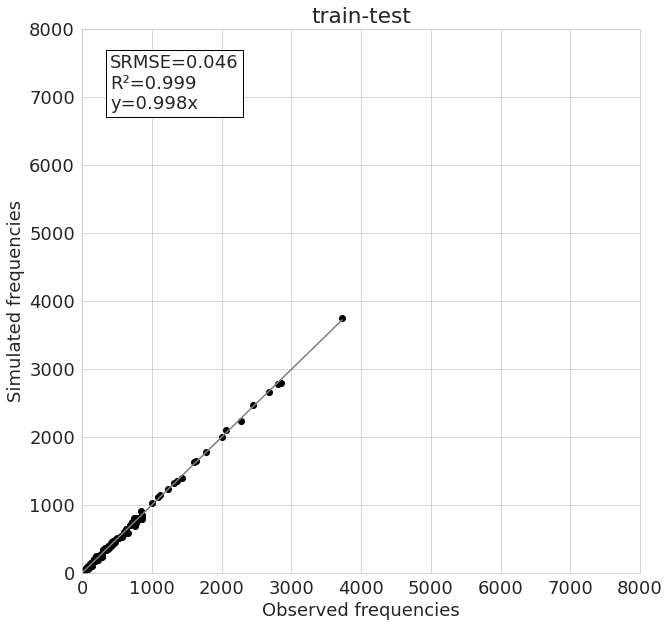

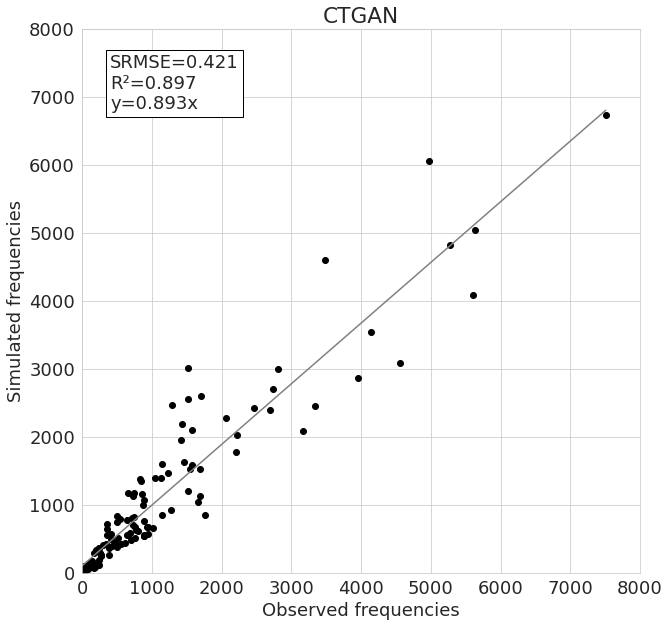

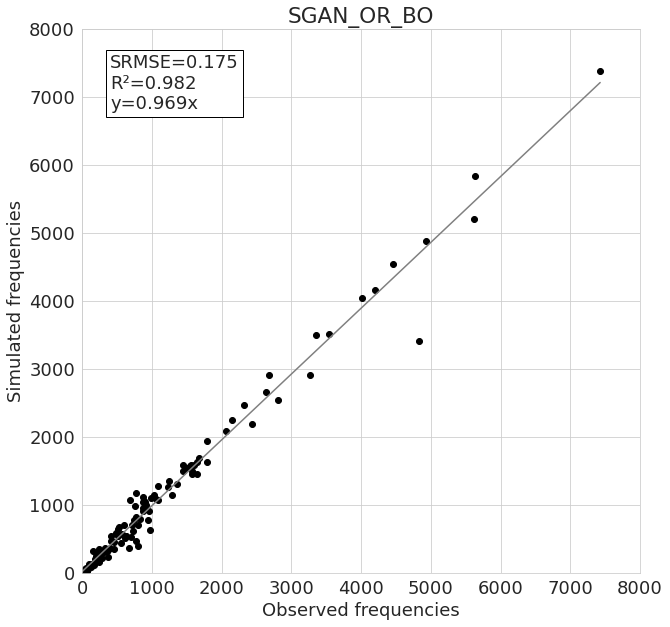

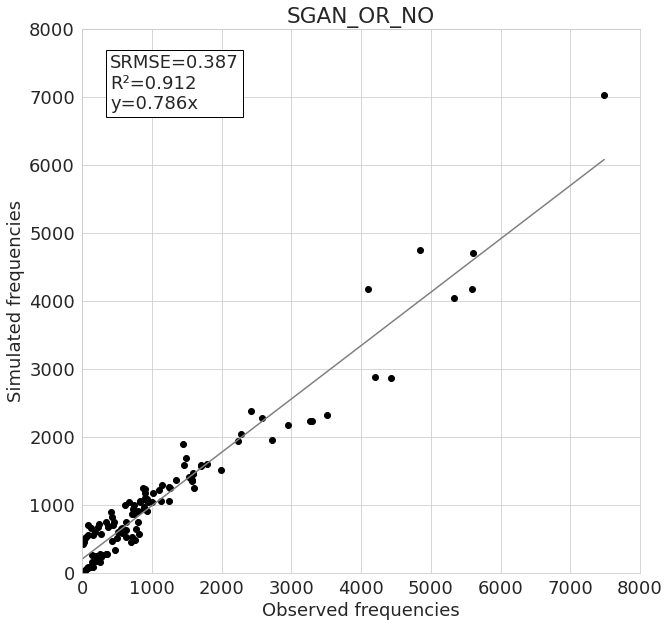

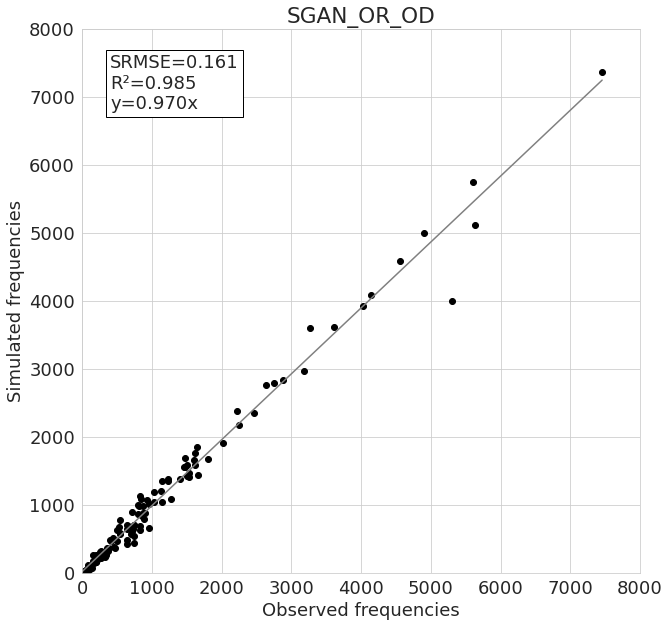

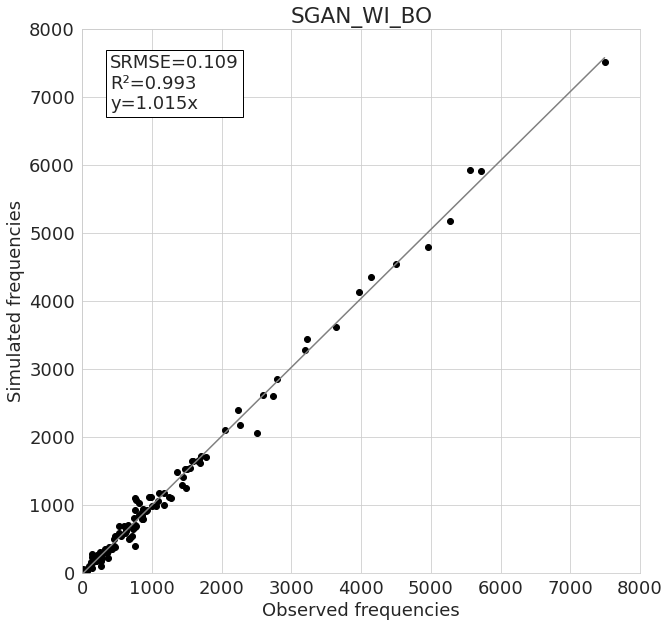

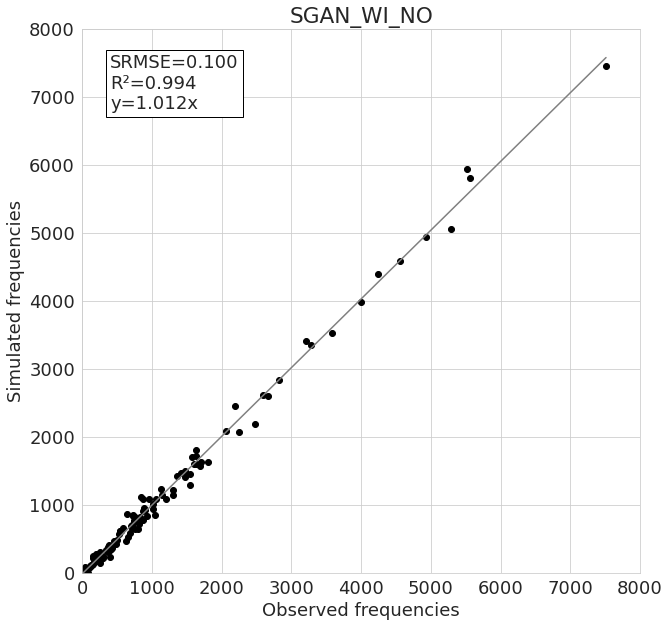

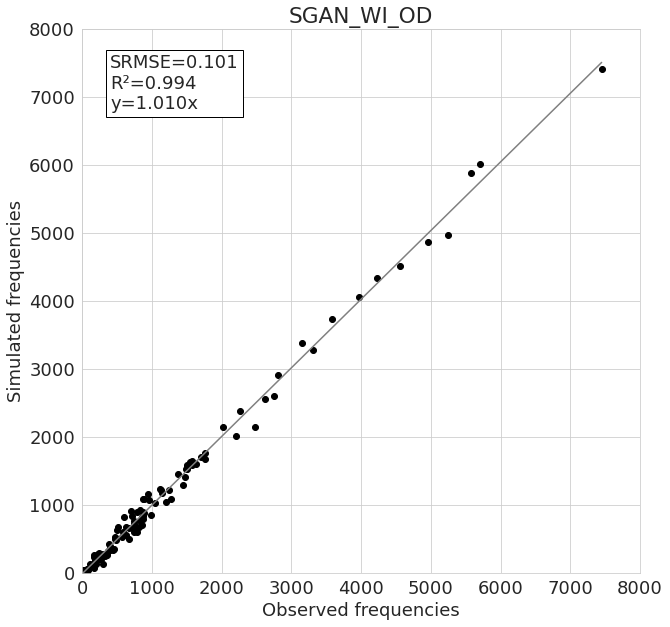

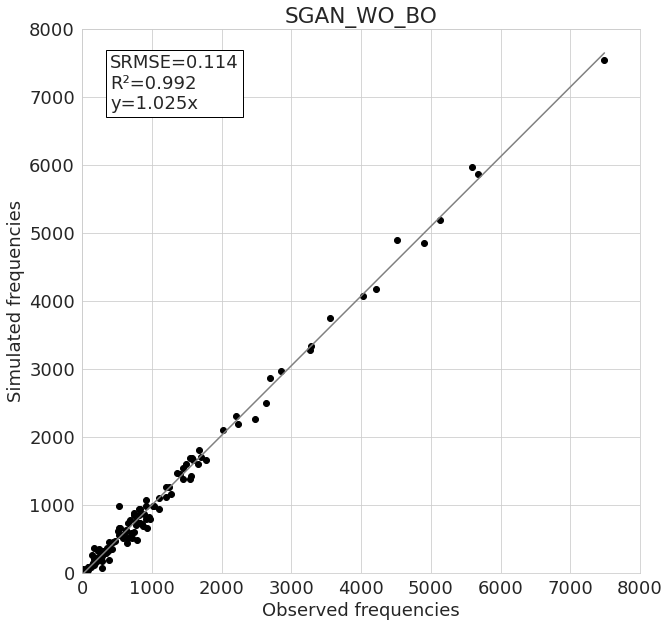

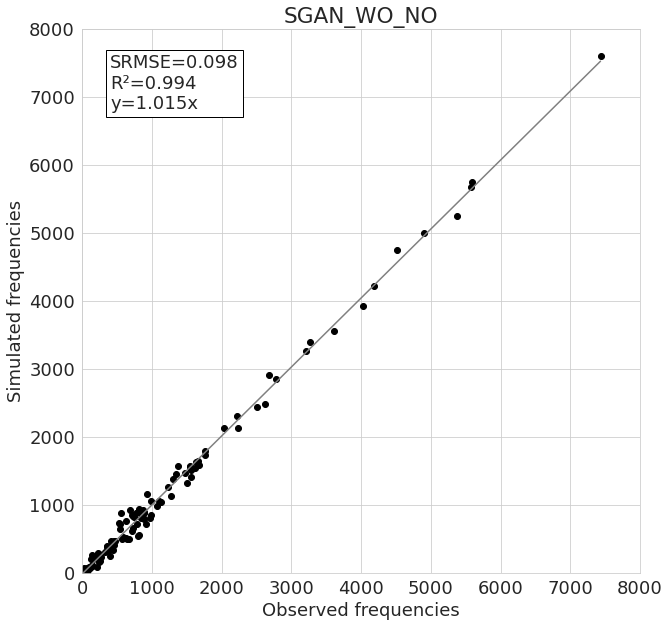

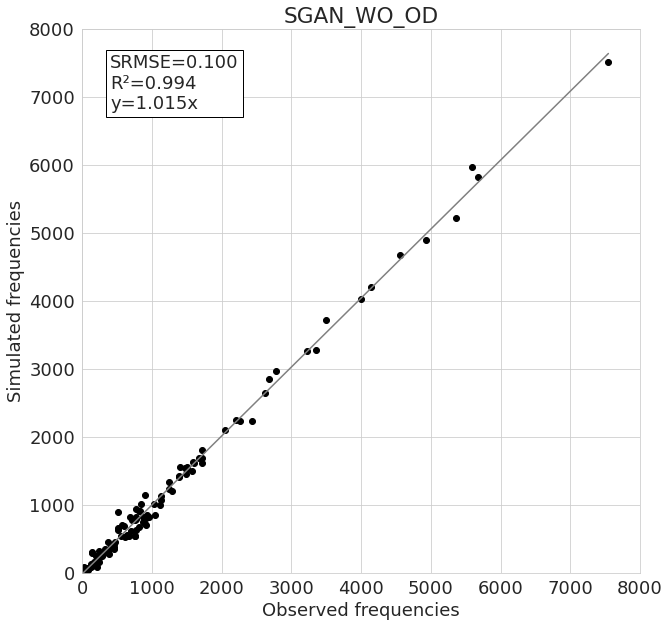

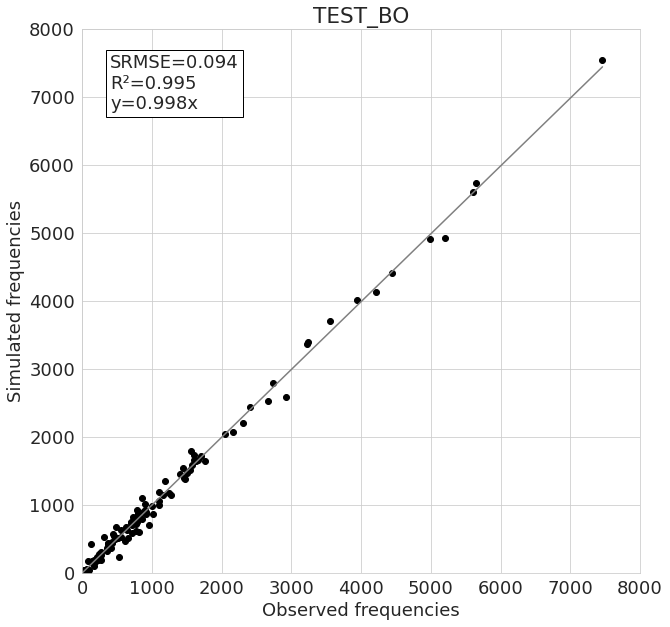

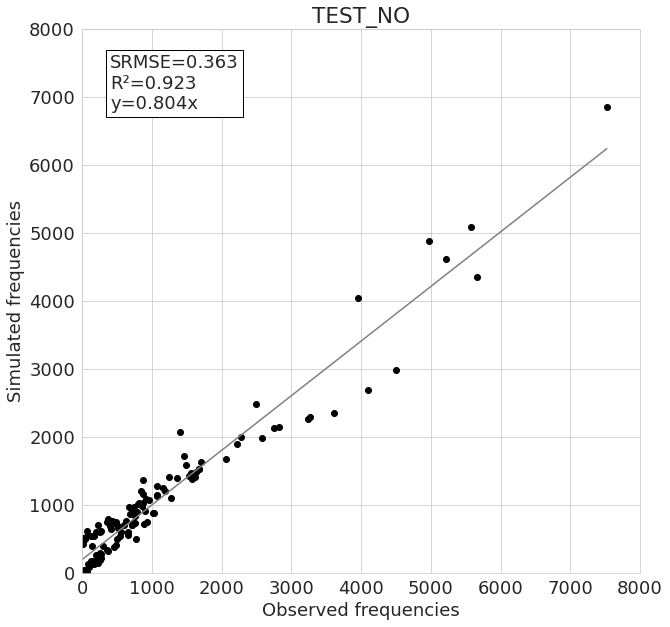

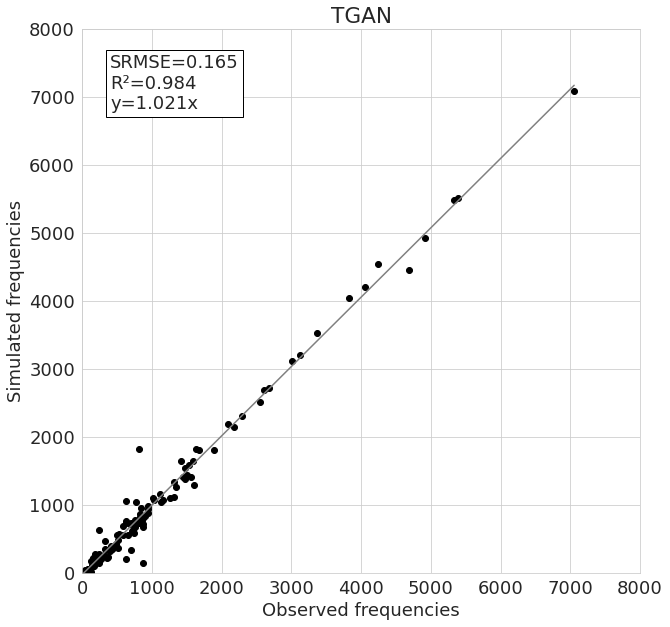

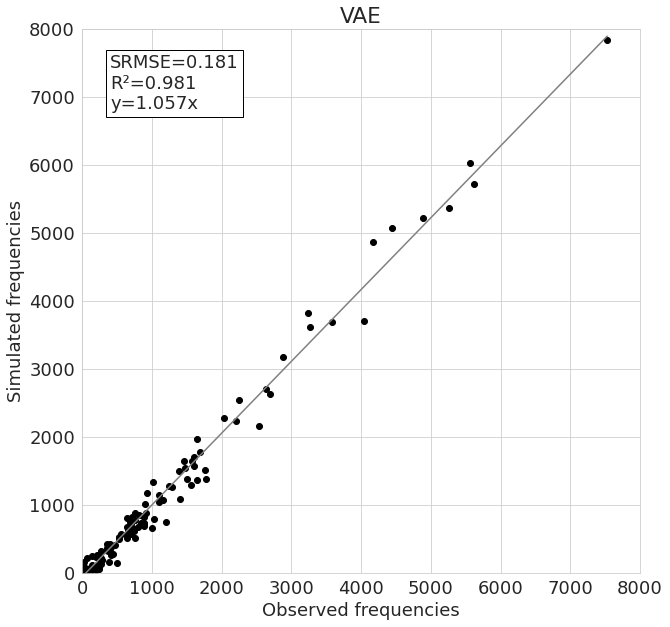

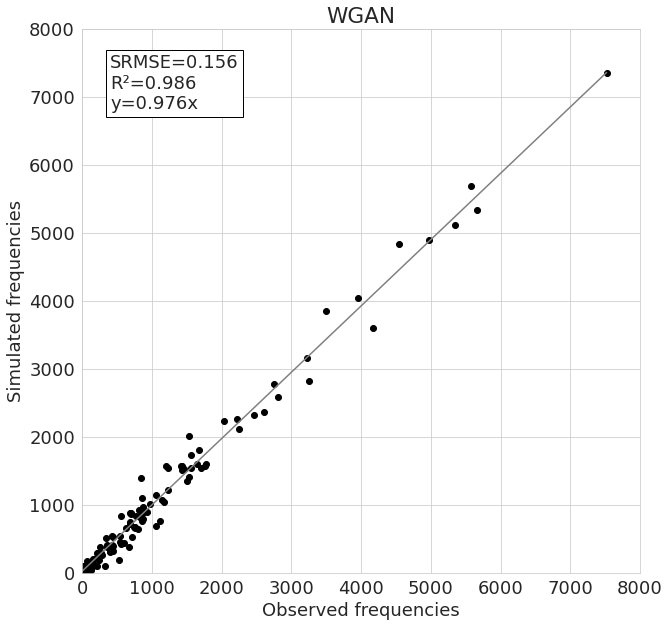

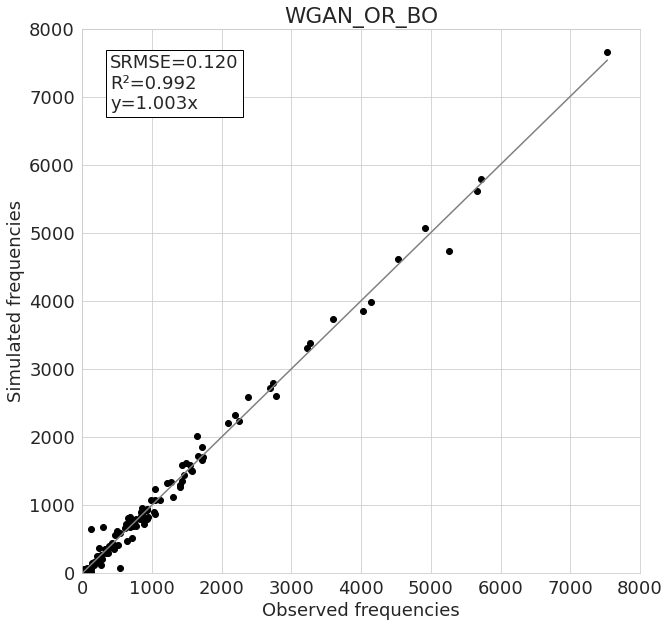

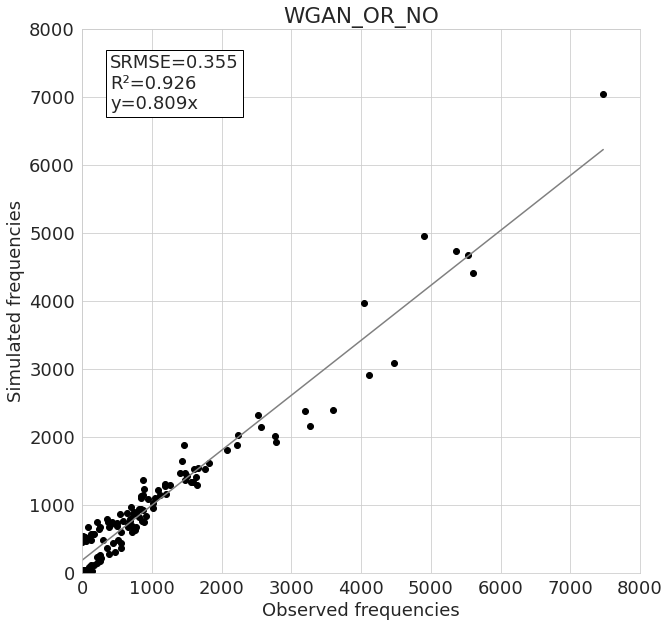

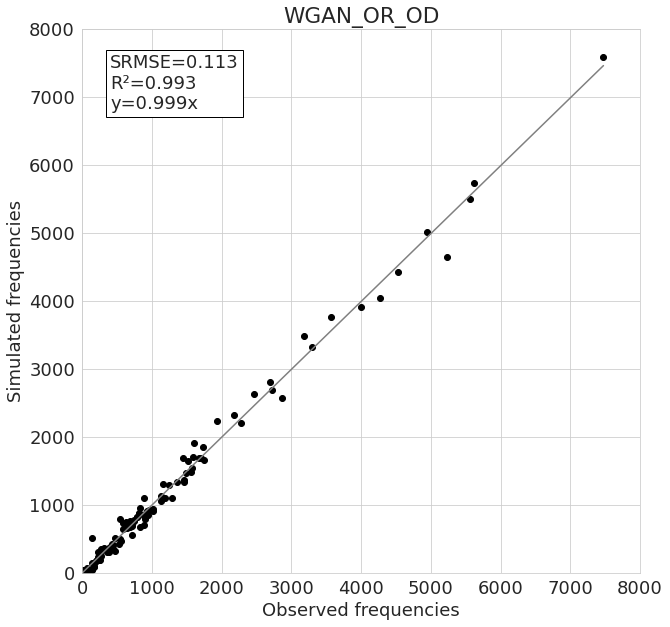

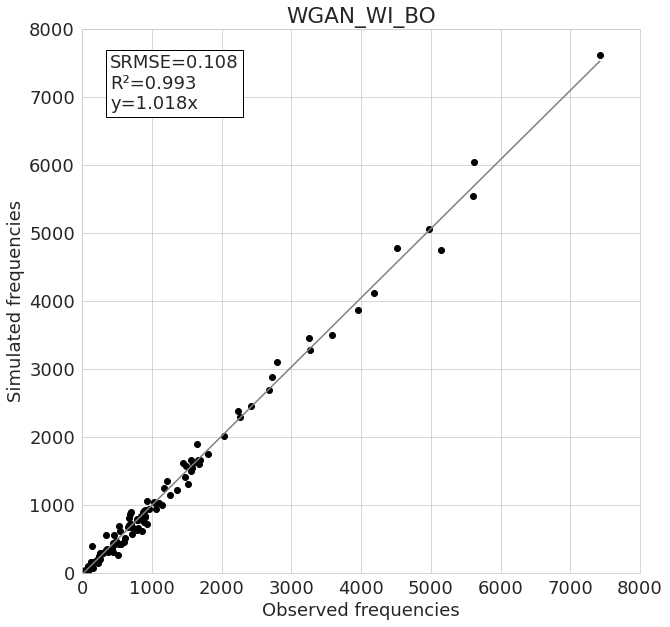

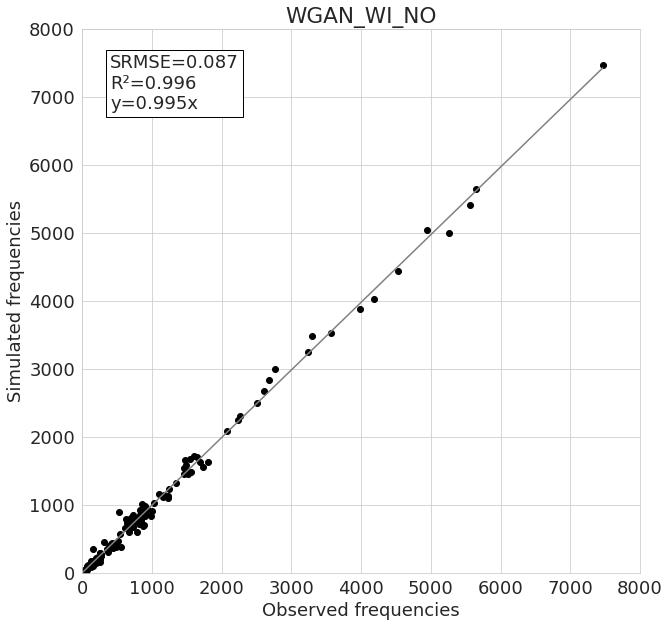

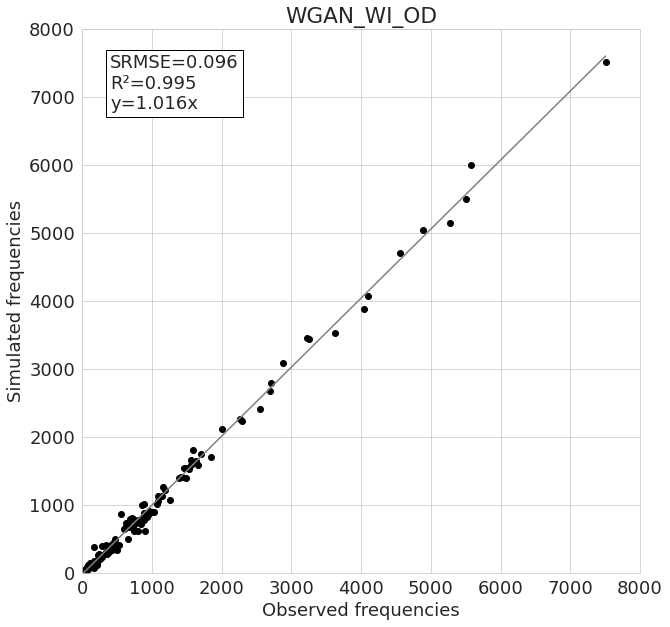

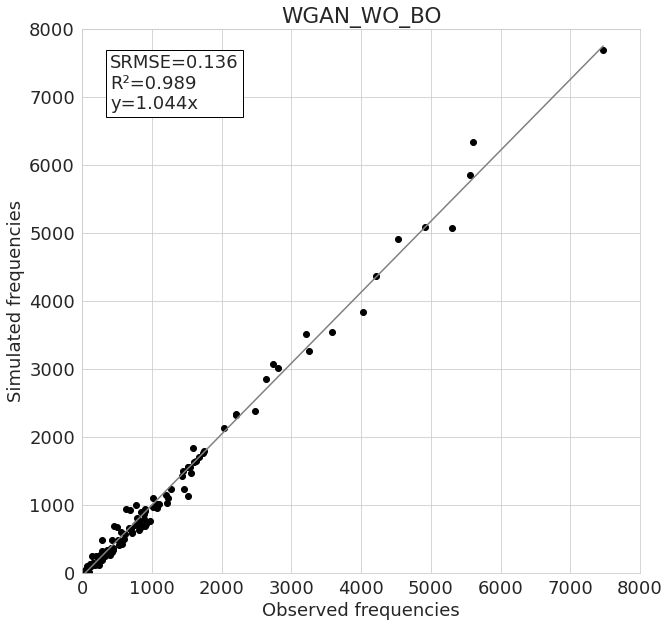

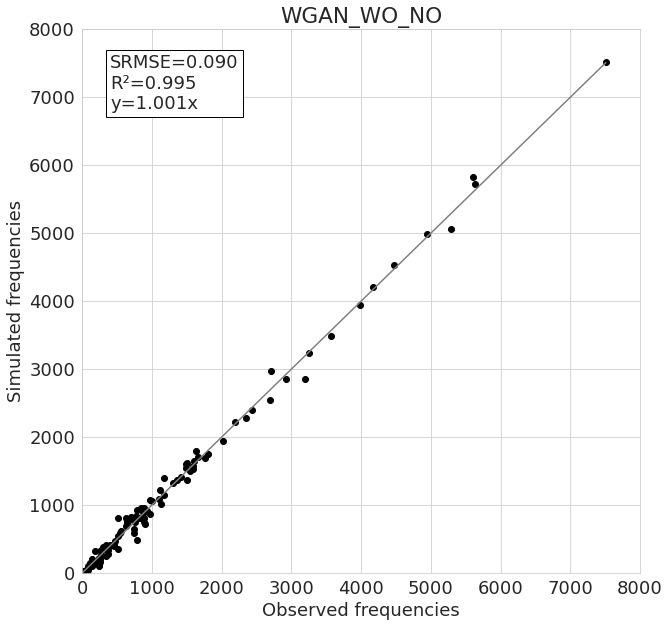

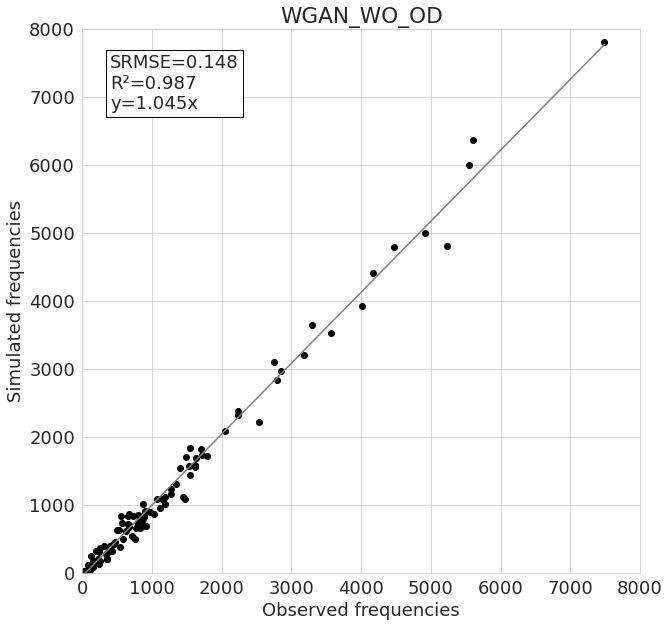

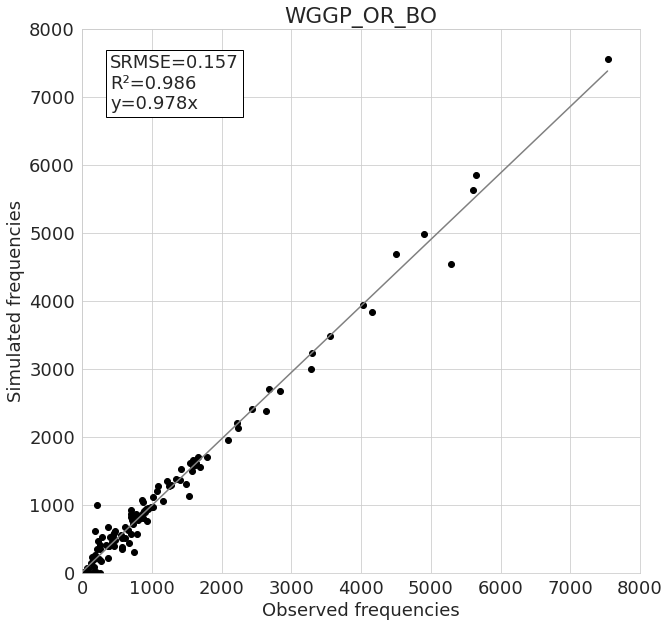

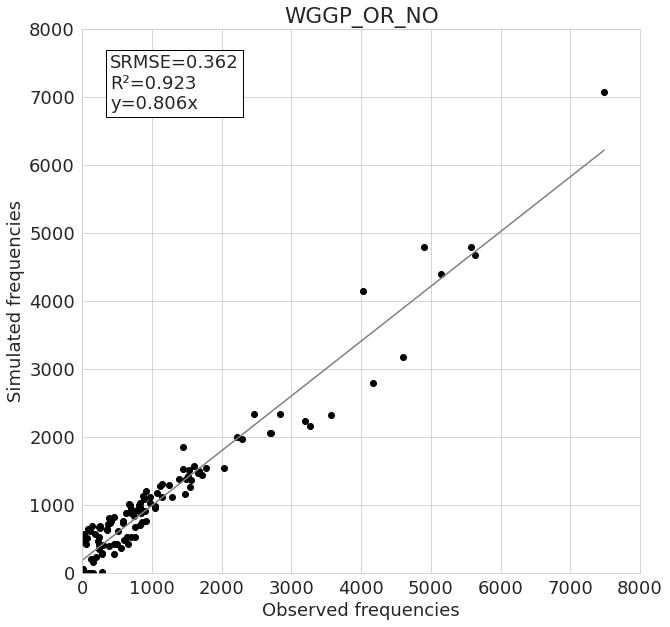

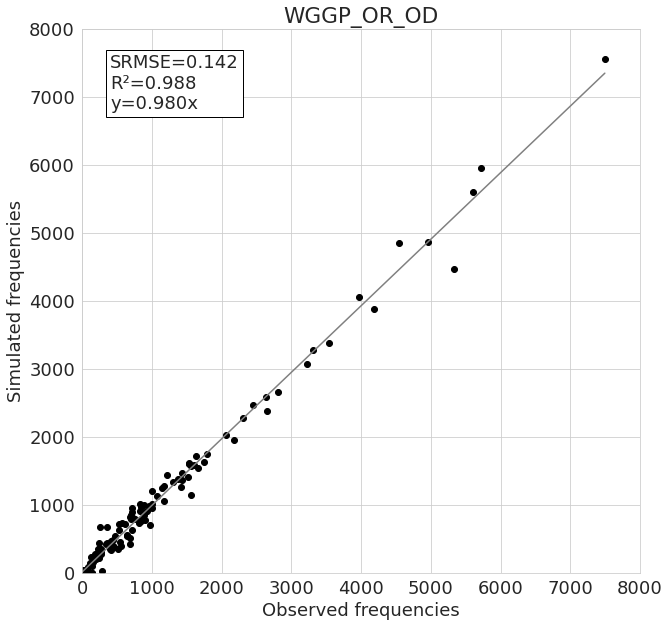

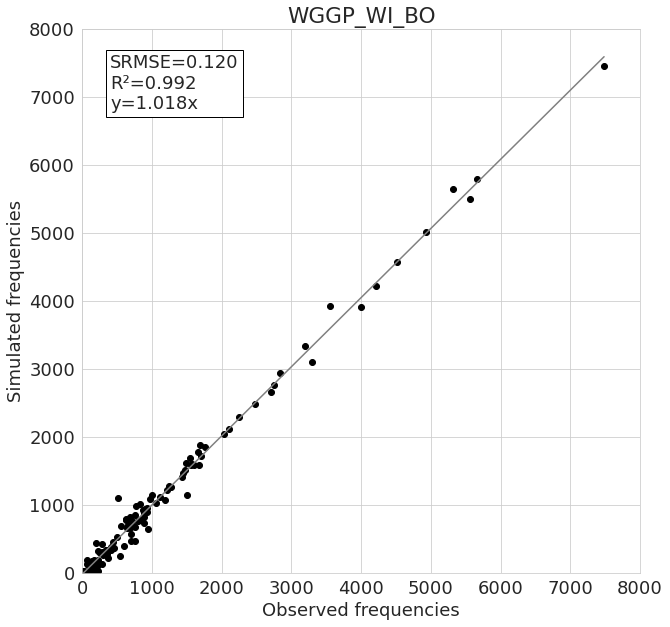

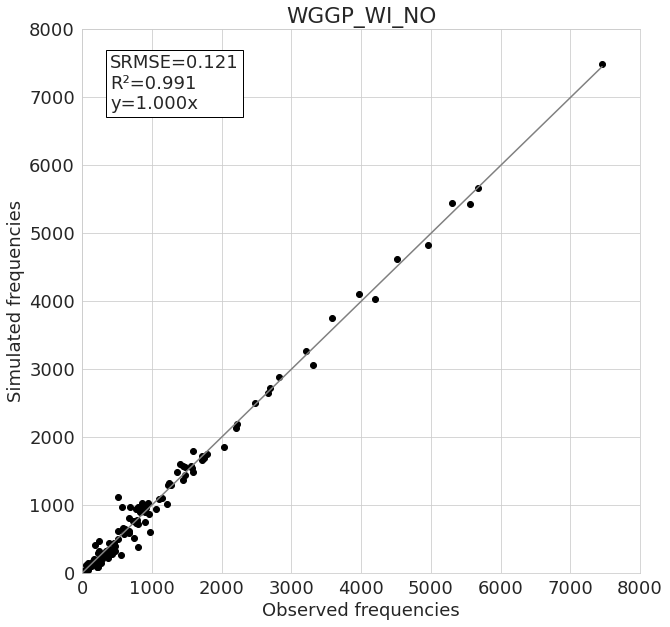

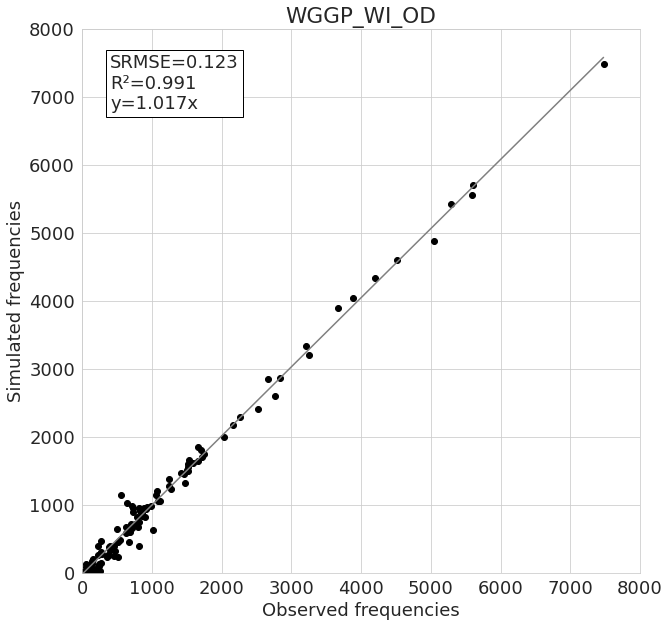

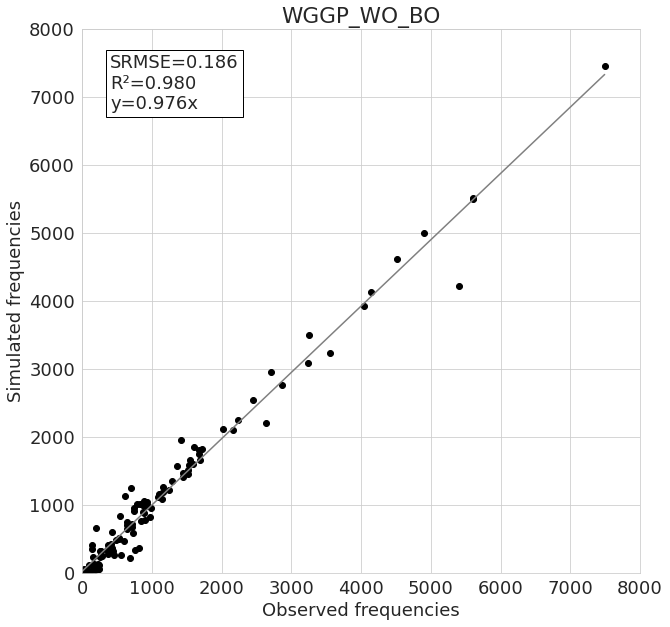

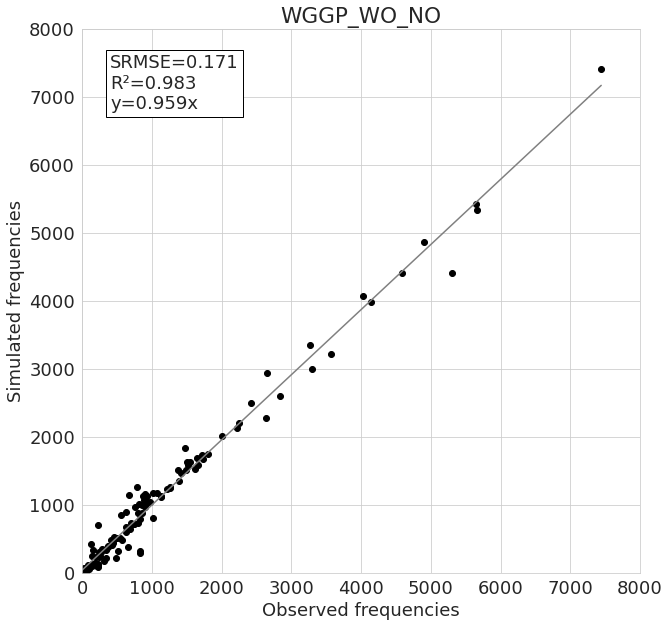

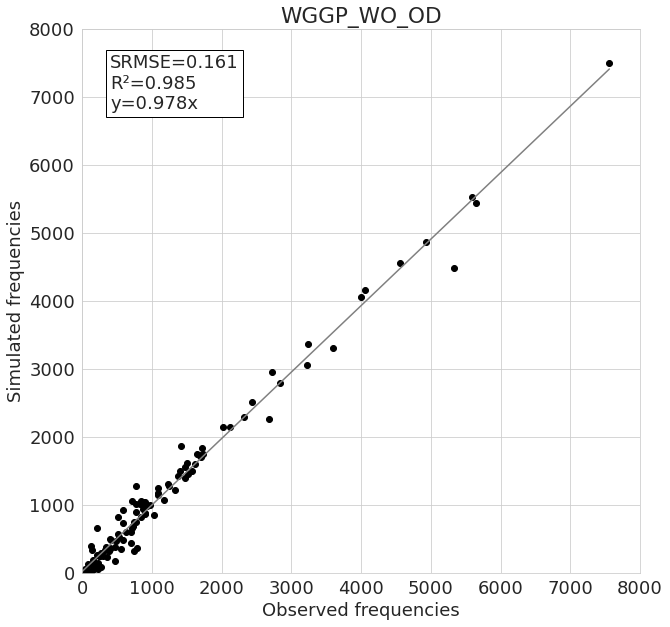

In [26]:
plot(train_freqs, test_freqs, 'train-test')#, '../figures/' + dataset + '/' + labels[i+1])
for i in range(len(synth_freqs)):
    plot(orig_freqs[i], synth_freqs[i], labels[i+1])#, '../figures/' + dataset + '/' + labels[i+1])

# Rankings

In [27]:
# possible values: 'mae', 'rmse', 'r2', 'srmse', 'corr'
str_ = 'srmse'

dct = {}
for i in range(len(synth_freqs)):
    stat = stats(orig_freqs[i], synth_freqs[i])
    dct[labels[i+1]] = stat[str_]

stat = stats(train_freqs, test_freqs)
dct['random-split'] = stat[str_]
    
if str_ in ['r2', 'corr']:
    sorted_dct = {k: v for k, v in sorted(dct.items(), key=lambda item: item[1])[::-1]}
else:
    sorted_dct = {k: v for k, v in sorted(dct.items(), key=lambda item: item[1])}

print('Ranking based on {}'.format(str_.upper()))
for i, item in enumerate(sorted_dct):
    print('  {:>2}. {:<25} - {:.3f}'.format(i+1, item, sorted_dct[item]))

Ranking based on SRMSE
   1. random-split              - 0.046
   2. WGAN_WI_NO                - 0.087
   3. WGAN_WO_NO                - 0.090
   4. TEST_BO                   - 0.094
   5. WGAN_WI_OD                - 0.096
   6. SGAN_WO_NO                - 0.098
   7. SGAN_WO_OD                - 0.100
   8. SGAN_WI_NO                - 0.100
   9. SGAN_WI_OD                - 0.101
  10. WGAN_WI_BO                - 0.108
  11. SGAN_WI_BO                - 0.109
  12. WGAN_OR_OD                - 0.113
  13. SGAN_WO_BO                - 0.114
  14. WGGP_WI_BO                - 0.120
  15. WGAN_OR_BO                - 0.120
  16. WGGP_WI_NO                - 0.121
  17. WGGP_WI_OD                - 0.123
  18. WGAN_WO_BO                - 0.136
  19. WGGP_OR_OD                - 0.142
  20. WGAN_WO_OD                - 0.148
  21. WGAN                      - 0.156
  22. WGGP_OR_BO                - 0.157
  23. WGGP_WO_OD                - 0.161
  24. SGAN_OR_OD                - 0.161
  25. TGAN       

# More details

In [28]:
stats_vals = []

for i in range(len(dfs)-1):
    stats_vals.append({'mae': [], 'rmse': [], 'r2': [], 'srmse': [], 'corr': []})

for c in dfs[0].columns:
    for i in range(1, len(dfs)):
        
        [a,b],bins = get_frequency_list(dfs[0][c], dfs[i][c], 50)
        
        stat = stats(a,b)
        
        for k in stat.keys():
            stats_vals[i-1][k].append(stat[k])
            
n = len(stats_vals)

msk = []
for i in dfs[0].columns:
    if i in continuous_cols:
        msk.append(True)
    else:
        msk.append(False)
msk = np.array(msk)

In [29]:
stat = 'srmse'

print("Weighted average of {} (continuous / categorical)".format(stat.upper()))
for i in range(n):
    print("  {:<25}: {:.3f} +- {:.3f} ({:.3f} +- {:.3f} / {:.3f} +- {:.3f})".format(
        labels[i+1], 
        np.mean(np.array(stats_vals[i]['srmse'])),
        np.std(np.array(stats_vals[i]['srmse'])),
        np.mean(np.array(stats_vals[i]['srmse'])[msk]), 
        np.std(np.array(stats_vals[i]['srmse'])[msk]), 
        np.mean(np.array(stats_vals[i]['srmse'])[~msk]), 
        np.std(np.array(stats_vals[i]['srmse'])[~msk])))

Weighted average of SRMSE (continuous / categorical)
  CTGAN                    : 0.380 +- 0.171 (0.542 +- 0.125 / 0.340 +- 0.156)
  SGAN_OR_BO               : 0.179 +- 0.269 (0.623 +- 0.333 / 0.067 +- 0.032)
  SGAN_OR_NO               : 0.347 +- 0.228 (0.497 +- 0.278 / 0.309 +- 0.197)
  SGAN_OR_OD               : 0.158 +- 0.217 (0.508 +- 0.278 / 0.071 +- 0.041)
  SGAN_WI_BO               : 0.119 +- 0.134 (0.368 +- 0.092 / 0.056 +- 0.029)
  SGAN_WI_NO               : 0.109 +- 0.117 (0.334 +- 0.042 / 0.053 +- 0.027)
  SGAN_WI_OD               : 0.110 +- 0.108 (0.318 +- 0.021 / 0.057 +- 0.029)
  SGAN_WO_BO               : 0.123 +- 0.139 (0.383 +- 0.080 / 0.058 +- 0.036)
  SGAN_WO_NO               : 0.109 +- 0.122 (0.344 +- 0.051 / 0.050 +- 0.029)
  SGAN_WO_OD               : 0.114 +- 0.132 (0.366 +- 0.066 / 0.051 +- 0.028)
  TEST_BO                  : 0.101 +- 0.108 (0.311 +- 0.008 / 0.049 +- 0.030)
  TEST_NO                  : 0.308 +- 0.171 (0.312 +- 0.066 / 0.307 +- 0.188)
  TGAN     

In [30]:
tmp = {}
tmp['continuous'] = []
tmp['categorical'] = []
stat = 'srmse'

names = ['TGAN', 'CTGAN', 'WGAN_WI']
list_ = []
for n in names:
    list_.append(labels.index(n))

for j, m in enumerate(list_):
    tmp['continuous'].append([])
    tmp['categorical'].append([])
    for i, c in enumerate(dfs[0].columns):
        name = 'continuous' if c in continuous_cols else 'categorical'
        tmp[name][j].append(stats_vals[m-1]['srmse'][i])

ValueError: 'WGAN_WI' is not in list

In [ ]:
plt.figure(figsize=(24,14), facecolor='white')
parts = plt.violinplot(tmp['continuous'], np.arange(len(list_)), showmeans=True)

for pc in parts['bodies']:
    pc.set_facecolor('black')
    pc.set_edgecolor('black')

parts['cbars'].set_edgecolor('black')
parts['cmaxes'].set_edgecolor('black')
parts['cmins'].set_edgecolor('black')
parts['cmeans'].set_edgecolor('black')

parts = plt.violinplot(tmp['categorical'], np.arange(len(list_)), showmeans=True)

for pc in parts['bodies']:
    pc.set_facecolor('red')
    pc.set_edgecolor('black')

parts['cbars'].set_edgecolor('red')
parts['cmaxes'].set_edgecolor('red')
parts['cmins'].set_edgecolor('red')
parts['cmeans'].set_edgecolor('red')

plt.yscale('log')

# 'fake' invisible object
black_patch = mpatches.Patch(color='black', alpha=0.5)
red_patch = mpatches.Patch(color='red', alpha=0.5)
label = ['Continuous', 'Categorical']

fake_handles = [black_patch, red_patch]
plt.legend(fake_handles, label, loc=2)


plt.xticks(np.arange(len(list_)), np.array(labels)[list_], rotation=45, ha='right')
plt.ylabel(stat.upper())